# Goal

Goal of given work is to study methods of dealing with imbalanced ds

Up-sample the minority class
Down-sample the majority class
Change your performance metric
Penalize algorithms (cost-sensitive training)
Use tree-based algorithms

# Load



In [64]:
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import train_test_split

from sklearn.utils import resample
import matplotlib.pyplot as plt

# Data

In [50]:
df=load_breast_cancer()

x=pd.DataFrame(df['data'])
y=pd.DataFrame(df['target'])

x.columns=df['feature_names']
y.columns=['TARGET']

#Unbalanced Dataset
print('Classes_proportion')
y['TARGET'].value_counts()

Classes_proportion


1    357
0    212
Name: TARGET, dtype: int64

In [51]:
X_train,X_val,y_train,y_val=train_test_split(x,y,test_size=0.17,shuffle=True,random_state=1,stratify=y)

# With test size 17% we have best split - train equal to test
print('Share_0/1_train\n', y_train['TARGET'].value_counts()/len(y_train))
print('Share_0/1_test\n', y_val['TARGET'].value_counts()/len(y_val))
print('----------------------------------------------------------')
print('Same Share in train_test')

Share_0/1_train
 1    0.627119
0    0.372881
Name: TARGET, dtype: float64
Share_0/1_test
 1    0.628866
0    0.371134
Name: TARGET, dtype: float64
----------------------------------------------------------
Same Share in train_test


# Baseline

In [52]:
#score baseline

m=XGBClassifier(random_state=234,n_jobs=-1)
m.fit(X_train,y_train)
pred=m.predict(X_val)
score=roc_auc_score(pred,y_val,average='weighted')
print('Baseline_Score:', score)

Baseline_Score: 0.9695852534562213


C:\anaconda1\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\anaconda1\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [53]:
score

0.9695852534562213

# 1. Create more minor class samples (syntetic) and combine with major

In [56]:
y_train['TARGET'].value_counts()

1    296
0    176
Name: TARGET, dtype: int64

       Score  Minor
2   0.984127    178
32  0.984127    208
84  0.976562    260
57  0.976562    233


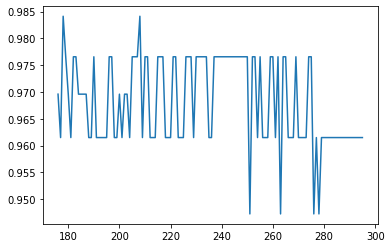

In [96]:
df=pd.concat([X_train,y_train],axis=1)
# Separate majority and minority classes
df_majority = df[df.TARGET==1]
df_minority = df[df.TARGET==0]
minor_i=[]
score_i=[]
 
for i in range(176,296):
# Upsample minority class
    minor_i.append(i)
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=i,    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    #print('We got balanced df')
    df_upsampled.TARGET.value_counts()

    m=XGBClassifier(random_state=234,n_jobs=-1)
    m.fit(df_upsampled.drop(['TARGET'],axis=1),df_upsampled.TARGET)
    pred=m.predict(X_val)
    score=roc_auc_score(pred,y_val,average='weighted')
    
    score_i.append(score)
score_i=pd.DataFrame(score_i)
minor_i=pd.DataFrame(minor_i)

score_resample=pd.concat([score_i,minor_i],axis=1)
score_resample.columns=['Score','Minor']
score_resample=score_resample.sort_values(by=['Score'], ascending=False)
print(score_resample[:4])
plt.plot(minor_i,score_i)


##### So, by edding 178 minor values we managed to improve our baseline score from 0.9695 to 0.9841.



Conclusion: Adding some amount syntetic minor class can help to improve baseline score.
Should be tested on Test_data!

# 2. Down-sample Majority Class

        Score  major
262  0.977914    264
245  0.977914    247
261  0.977914    263
258  0.977914    260


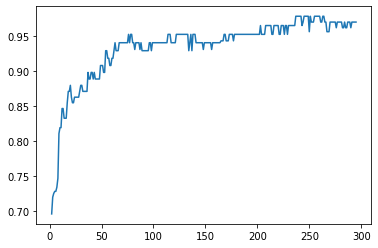

In [100]:
df=pd.concat([X_train,y_train],axis=1)
# Separate majority and minority classes
df_majority = df[df.TARGET==1]
df_minority = df[df.TARGET==0]
major_i=[]
score_i=[]
 
for i in range(2,296):
# Upsample minority class
    major_i.append(i)
    df_majority_upsampled = resample(df_majority, 
                                     replace=True,     # sample with replacement
                                     n_samples=i,    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_downsampled = pd.concat([df_minority, df_majority_upsampled])

    # Display new class counts
    #print('We got balanced df')
    df_downsampled.TARGET.value_counts()

    m=XGBClassifier(random_state=234,n_jobs=-1)
    m.fit(df_downsampled.drop(['TARGET'],axis=1),df_downsampled.TARGET)
    pred=m.predict(X_val)
    score=roc_auc_score(pred,y_val,average='weighted')
    
    score_i.append(score)
score_i=pd.DataFrame(score_i)
major_i=pd.DataFrame(major_i)

score_resample=pd.concat([score_i,major_i],axis=1)
score_resample.columns=['Score','major']
score_resample=score_resample.sort_values(by=['Score'], ascending=False)
print(score_resample[:4])
plt.plot(major_i,score_i)


##### So, by dropping 264 major values we managed to improve our baseline score from 0.9695 to 0.9779.